In [1154]:
from tensorflow import keras, config
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Set a global random state so that the nn gives the same results each time
keras.utils.set_random_seed(69)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
config.experimental.enable_op_determinism()

## Data analysis

In [1155]:
csv_path: str = "../daily-order-bot/BTC-1D-PRICE-HISTORY.csv"
price_data = pd.read_csv(csv_path)

## Features

In [1156]:
price_open = price_data.open
price_close = price_data.close
price_high = price_data.high
price_low = price_data.low
price_vol = price_data.volume

#### Create label targets

In [1157]:
target = []

for row in range(len(price_open)):
    
    if price_close[row] - price_open[row] > 0:
        target.append("long")
    else:
        target.append("short")

price_data["target"] = target

#### Add days and months from date col

In [1158]:
dates = price_data.date
day_list = []
month_list = []

for row in dates:
    day = row.split("-")[0]
    month = row.split("-")[2]

    day_list.append(day)
    month_list.append(month)

price_data["day"] = day_list
price_data["month"] = month_list

In [1159]:
price_data = price_data.drop(["date", "time"], axis=1)

#### Daily change (Feature)

In [1160]:
daily_change = [0]

for row in range(len(price_open)):

    if row == 0:
        continue

    change = (price_open[row] - price_open[row-1]) / price_open[row - 1] * 100
    daily_change.append(round(change,8))

price_data["daily_change"] = daily_change

#### Volitility (Feature) *Currently not used

In [1161]:
volitility = [0, 0 ]

for row in range(len(price_high)):

    if row == 0 or row == 1:
        continue

    vol = (price_high[row-2] - price_low[row-2]) /100
    volitility.append(vol)

price_data["volitility"] = volitility



In [1162]:
highs = [0, 0]
lows = [0, 0]
highs_from_open = [0, 0]
lows_from_open = [0, 0]

for row in range(len(price_high)):

    if row == 0 or row == 1:
        continue

    highs.append(price_high[row-2]/1000)
    lows.append(price_low[row-2]/1000)

    highs_from_open.append((price_high[row-2]-price_open[row-2])/10000)
    lows_from_open.append((price_low[row-2]-price_open[row-2])/10000)
# lows from open and highs from open
price_data["high"] = highs
price_data["low"] = lows

price_data["highs_from_open"] = highs_from_open
price_data["lows_from_open"] = lows_from_open

In [1163]:
volume = [0, 0]

for row in range(len(price_vol)):

    if row == 0 or row == 1:
        continue
    
    volume.append(price_vol[row-2]/1000000000)
    
price_data["volume"] = volume
price_data.tail(5)

,open,high,low,close,volume,target,day,month,daily_change,volitility,highs_from_open,lows_from_open
1025,63178,63.436,60.064,62839,8.614548,short,Sun,Oct,1.084800,33.72,0.3140,-0.0232
1026,62839,63.467,62.458,66080,3.585749,long,Mon,Oct,-0.536579,10.09,0.0967,-0.0042
1027,66080,63.270,62.012,67057,4.559809,long,Tue,Oct,5.157625,12.58,0.0092,-0.1166
1028,67057,67.300,62.422,67595,11.567526,long,Wed,Oct,1.478511,48.78,0.4461,-0.0417
1029,67595,67.999,64.762,67437,15.131724,short,Thu,Oct,0.802303,32.37,0.1919,-0.1318


## ML Workflow

#### Encoding

In [1164]:
# Ecode all text features to numbers for the nn to use

day_encoder = LabelEncoder()
month_encoder = LabelEncoder()
target_encoder = LabelEncoder()

day = day_encoder.fit_transform(price_data.day)
price_data["day"] = day

month = month_encoder.fit_transform(price_data.month)
price_data["month"] = month

target = target_encoder.fit_transform(price_data.target)
price_data["target"] = target

In [1165]:
# Select the features to be used in training the nn
X = price_data.filter(["day", "month", "daily_change",  "volitility","volume", "highs_from_open", "lows_from_open", "target",]) # "volume", "low", "high", "volitility", "highs_from_open", "lows_from_open"
# Split the training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X.drop("target", axis=1), X.target ,random_state = 42)

# Split the alidation and training sets
X_val, X_train = X_train_full[:100], X_train_full[100:]
y_val, y_train = y_train_full[:100], y_train_full[100:]

# Get the number of features in the dataset by isolating the second number in "shape", this is needed to feed into the
# NN inputlayer
input_shape = X_train_full.shape[1]

In [1166]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

#### NN model

In [1167]:
# Build the nn model

#1
#train 61, vval 64, test, 60 loss 6834, epoch 475
model = keras.models.Sequential([
              keras.layers.InputLayer(shape=(input_shape,)),         
              keras.layers.Dense(73, activation="relu"),
              keras.layers.Dense(51, activation="relu"), 
              keras.layers.Dense(25, activation="relu"), 
              keras.layers.Dense(5, activation="relu"),
              keras.layers.Dense(2, activation="softmax")
          ])


#2
# train:62, val: 60, test: 59, loss 6809, e:175
# model = keras.models.Sequential([
#     keras.layers.InputLayer(shape=(input_shape,)), 
#     keras.layers.Dense(357, activation="relu"),
#     keras.layers.Dense(325, activation="relu"),
#     keras.layers.Dense(95, activation="relu"),
#     keras.layers.Dense(25, activation="relu"),
#     keras.layers.Dense(2, activation="softmax")
#           ])

#3
#train 62 6698, val 59 6682, test 59 6858 epoch 250
# model = keras.models.Sequential([
#     keras.layers.InputLayer(shape=(input_shape,)), 
#     keras.layers.Dense(175, activation="relu"),
#     keras.layers.Dense(101, activation="relu"),
#     keras.layers.Dense(77, activation="relu"),
#     keras.layers.Dense(25, activation="relu"),
#     keras.layers.Dense(2, activation="softmax")
#           ])

# 57 275 but better all round
# model = keras.models.Sequential([
#               keras.layers.InputLayer(shape=(input_shape,)), 
#               keras.layers.Dense(101, activation="relu"), 
#               keras.layers.Dense(71, activation="relu"),
#               keras.layers.Dense(25, activation="relu"), 
#               keras.layers.Dense(2, activation="softmax")
#           ])

#57 350
# model = keras.models.Sequential([
#               keras.layers.InputLayer(shape=(input_shape,)), 
#               keras.layers.Dense(301, activation="relu"), 
#               keras.layers.Dense(101, activation="relu"),
#               keras.layers.Dense(75, activation="relu"),
#               keras.layers.Dense(25, activation="relu"),
#               keras.layers.Dense(2, activation="softmax")
#           ])

# 57 150
# model = keras.models.Sequential([
#     keras.layers.InputLayer(shape=(input_shape,)), 
#     keras.layers.Dense(955, activation="relu"),
#     keras.layers.Dense(505, activation="relu"),
#     keras.layers.Dense(25, activation="relu"),
#               keras.layers.Dense(2, activation="softmax")
#           ])



In [1168]:
# model.compile(loss="binary_crossentropy",
#              optimizer=keras.optimizers.SGD(learning_rate=0.001),
#              metrics=["accuracy"])

model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(learning_rate=0.001),
             metrics=["accuracy"])


#### Training

In [1169]:
history = model.fit(X_train, y_train, epochs=475, validation_data=(X_val, y_val))

Epoch 1/475
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5071 - loss: 0.7369 - val_accuracy: 0.5400 - val_loss: 0.6948
Epoch 2/475
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5069 - loss: 0.7165 - val_accuracy: 0.5300 - val_loss: 0.6893
Epoch 3/475
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4859 - loss: 0.7128 - val_accuracy: 0.5500 - val_loss: 0.6889
Epoch 4/475
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4829 - loss: 0.7094 - val_accuracy: 0.5600 - val_loss: 0.6864
Epoch 5/475
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4844 - loss: 0.7068 - val_accuracy: 0.5500 - val_loss: 0.6845
Epoch 6/475
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5081 - loss: 0.7046 - val_accuracy: 0.5700 - val_loss: 0.6839
Epoch 7/475
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5013 - loss: 0.7045 - val_accuracy: 0.5700 - val_loss: 0.6831
Epoch 8/475
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4897 - loss: 0.7031 - val_accuracy: 0.5800 

#### Visualization

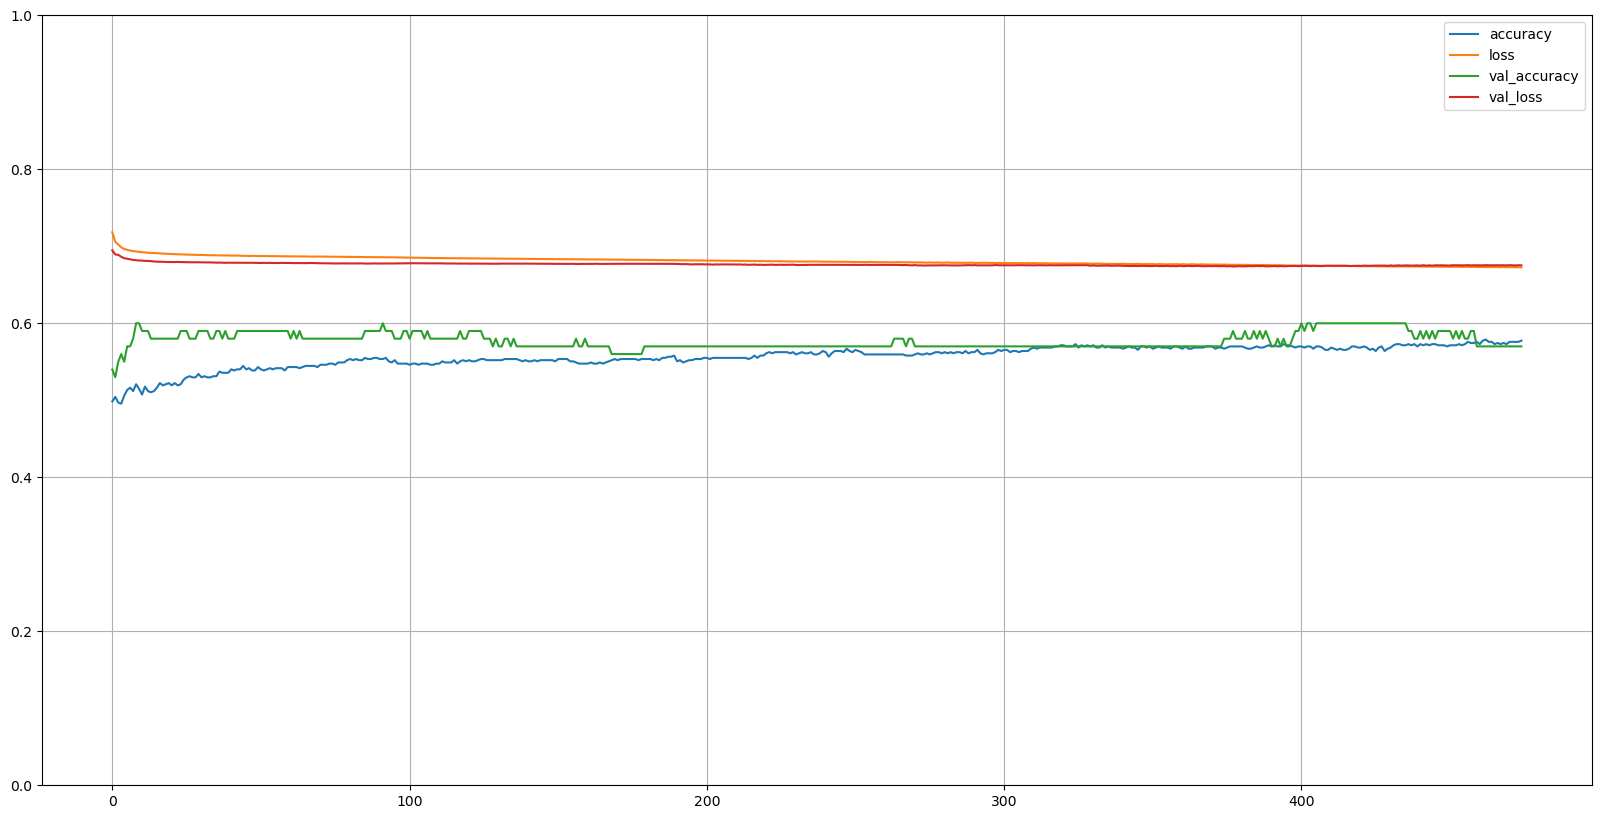

In [1171]:
pd.DataFrame(history.history).plot(figsize=(20, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


## Results

#### Testing

In [1172]:
model.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5169 - loss: 0.7036


[0.6921988725662231, 0.538759708404541]

In [1151]:
X_new = X_test[:5]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


array([[0.5 , 0.5 ],
       [0.51, 0.49],
       [0.52, 0.48],
       [0.56, 0.44],
       [0.4 , 0.6 ]], dtype=float32)

In [1110]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array([0, 1, 0, 0, 1], dtype=int64)

In [1111]:
y_new = y_test[:5]
y_new

290    0
534    1
261    0
107    0
425    1
Name: target, dtype: int32

In [1112]:
c = price_data[-1:]

price = [val for val in c.open]
price[0]

67057

In [1113]:
c = c.filter(["day", "month", "daily_change","volume", "volitility", "highs_from_open", "lows_from_open"]) #, "volitility", "highs_from_open", "lows_from_open", , "low", "high" , "volitility", "highs_from_open", "lows_from_open", "low", "high" , "volitility", "highs_from_open", "lows_from_open"


In [1114]:
h = np.argmax(model.predict(c), axis=-1)
h

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


array([1], dtype=int64)